**A Framework for Anxiety and Depression Detection: From Baselines to Explainable Machine Learning Models.**

Understanding/Detecting Anxiety & Depression through Text Classification and Model Explainability using LIME

https://www.kaggle.com/datasets/sahasourav17/students-anxiety-and-depression-dataset/discussion/518498

BACKGROUND AND MOTIVATION

Mental health issues like anxiety and depression are increasingly prevalent among students, impacting academic performance and overall well-being. Identifying signs of these conditions through written expressions (e.g., social media posts, diary entries) can facilitate early intervention. While advanced machine learning models can classify such text effectively, their lack of transparency hinders trust and adoption in sensitive fields like mental health.
This project aims to bridge the gap by developing a classification model for detecting anxiety and depression in text, augmented with LIME-based explainability to understand the driving factors behind predictions.


OBJECTIVES



1.   Build a robust text classification model to detect anxiety and depression.
2.   Utilize LIME to interpret model predictions at both global (dataset-wide) and local (individual text) levels.
3.   Identify key features (e.g., words, phrases) contributing to the classification of anxiety and depression.
4.   Compare the explainability and performance of a baseline model and an advanced transformer-based model.


RESEARCH QUESTIONS
1.   How accurately can text data classify anxiety and depression?
2.   Which words or phrases are most influential in the detection of anxiety and depression?
3.   How do LIME values enhance the interpretability of classification models in mental health applications?


METHODOLOGY

LIBRARIES

In [1]:
# # Install the scikit-plot package
# !pip install scikit-plot
# !pip install --upgrade scikit-plot
# !pip install spacy
# !pip install emoji
# !pip install numpy==1.23.5 scipy==1.9.3

# Install necessary libraries with specific versions
!pip install scikit-plot
!pip install --upgrade scikit-plot
!pip install spacy
!pip install emoji
!pip install numpy==1.23.5 scipy==1.9.3 matplotlib==3.5.3 seaborn==0.11.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 35.8 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled 

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import emoji

import spacy
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from textblob import TextBlob
from scipy.sparse import hstack

from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict

from scikitplot.metrics import plot_confusion_matrix, plot_roc

from lime.lime_text import LimeTextExplainer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


DATA & EXPLORATION

The dataset is annotated and comprises 2 columns: text (social media/Facebook comments/posts), and label.  
The dataset contains 6,982 rows of student text labeled for anxiety and depression (binary classification).
Labels:
1: Indicates anxiety/depression
0: Indicates absence of anxiety/depression

In [10]:
df = pd.read_excel('dataset.xlsx')
df.head()

text  label
0                                         oh my gosh    1.0
1  trouble sleeping, confused mind, restless hear...    1.0
2  All wrong, back off dear, forward doubt. Stay ...    1.0
3  I've shifted my focus to something else but I'...    1.0
4  I'm restless and restless, it's been a month n...    1.0

In [11]:
print(df.shape) #how many rows

(6982, 2)


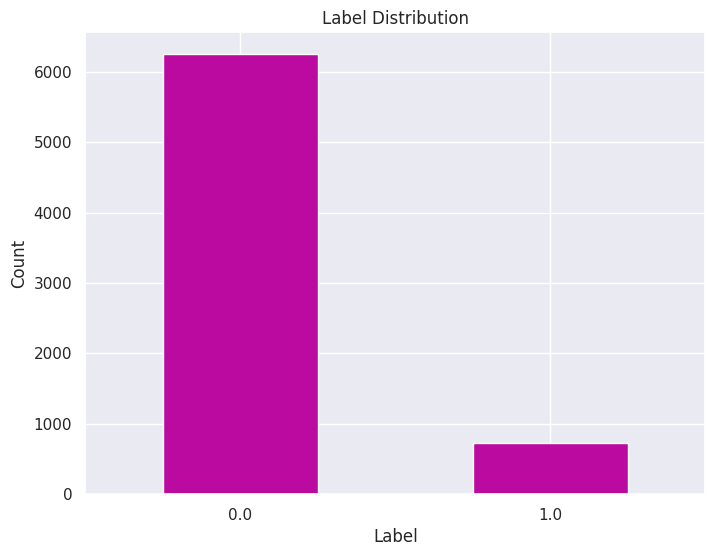

In [12]:
#count the occurrences of each label
label_distribution = df['label'].value_counts()

#bar chart
plt.figure(figsize=(8, 6))
label_distribution.plot(kind='bar', color='#BB0AA0')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

*The bar chart shows that less than 1000 students' comments were labeled with anxiety/depression, while the majority were not.*

*Also shows a highly imbalanced dataset. Need for oversampling.*

*For basline model: SMOTE (Synthetic Minority Oversampling Technique) generates realistic synthetic samples for the minority class, preserving the dataset's size and richness while addressing the imbalance.*

*For transformer: Class weights enhance interpretability by highlighting how the model handles misclassifications, which is crucial for sensitive areas like mental health.*

PREPROCESSING

Handling missing data

In [13]:
#check for missing data
df.isnull().sum()

text     10
label     2
dtype: int64

the text column has 10 missing values and the label column has 2 missing values

In [14]:
#drop the missing rows
df=df.dropna(how='any')
df.isnull().sum()

text     0
label    0
dtype: int64

In [15]:
df['label'].value_counts()

label
0.0    6240
1.0     730
Name: count, dtype: int64

Data Cleaning - convert to lowercase, remove links, punctuations (except apostrophes), white spaces, stopwords, emojis, and lemmatize

In [16]:
df.head()

text  label
0                                         oh my gosh    1.0
1  trouble sleeping, confused mind, restless hear...    1.0
2  All wrong, back off dear, forward doubt. Stay ...    1.0
3  I've shifted my focus to something else but I'...    1.0
4  I'm restless and restless, it's been a month n...    1.0

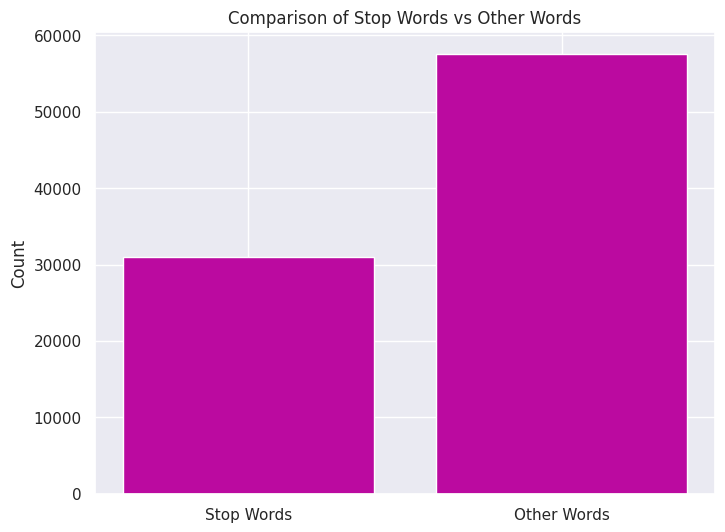

In [17]:
#chart to illustrate stopword counts compared to other words in the text column

#count stop words and other words
def count_words(text):
    if isinstance(text, str):
        words = text.split()
        stop_words_count = sum(1 for word in words if word in stop_words)
        other_words_count = len(words) - stop_words_count
        return stop_words_count, other_words_count
    return 0, 0

#applying the count function to the text column
df['stop_words_count'], df['other_words_count'] = zip(*df['text'].apply(count_words))

#aggregate the counts for all rows
total_stop_words = df['stop_words_count'].sum()
total_other_words = df['other_words_count'].sum()

#Bar chart to compare stop words and others
plt.figure(figsize=(8, 6))
plt.bar(['Stop Words', 'Other Words'], [total_stop_words, total_other_words], color=['#BB0AA0', '#BB0AA0'])
plt.title('Comparison of Stop Words vs Other Words')
plt.ylabel('Count')
plt.show()

In [18]:
#convert to lower case, remove links, punctuations (retain apostrophes) and whitespaces
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  #lowercase
        text = re.sub(r'http\S+|www\S+', '', text)  #remove links
        text = re.sub(r"[^\w\s']", '', text)  #remove punctuations except apostrophes
        text = text.strip()  #remove leading/trailing whitespace
        text = ' '.join([word for word in text.split() if word not in stop_words])  #remove stop words
        return text
    return text

df['text'] = df['text'].apply(clean_text)
df.head()

text  label  stop_words_count  \
0                                            oh gosh    1.0                 1   
1  trouble sleeping confused mind restless heart ...    1.0                 2   
2  wrong back dear forward doubt stay restless re...    1.0                 4   
3  i've shifted focus something else i'm still wo...    1.0                 3   
4               i'm restless restless month boy mean    1.0                 6   

   other_words_count  
0                  2  
1                  8  
2                 10  
3                  8  
4                  8

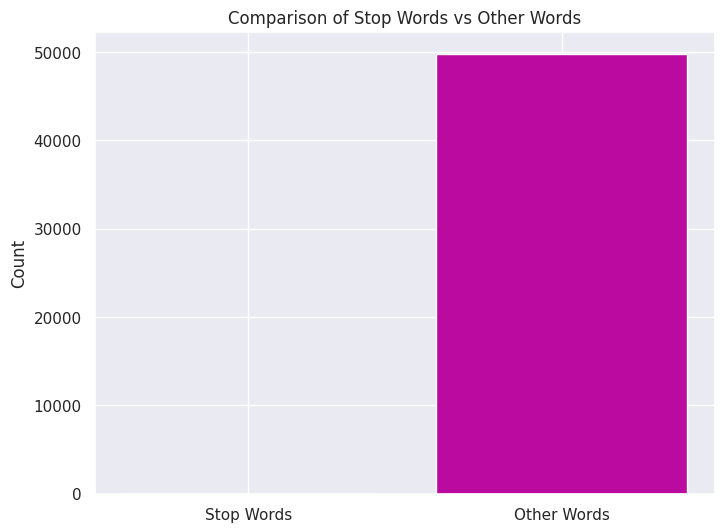

In [19]:
#chart to illustrate stopword counts compared to other words in the text column

#count stop words and other words
def count_words(text):
    if isinstance(text, str):
        words = text.split()
        stop_words_count = sum(1 for word in words if word in stop_words)
        other_words_count = len(words) - stop_words_count
        return stop_words_count, other_words_count
    return 0, 0

#applying the count function to the text column
df['stop_words_count'], df['other_words_count'] = zip(*df['text'].apply(count_words))

#aggregate the counts for all rows
total_stop_words = df['stop_words_count'].sum()
total_other_words = df['other_words_count'].sum()

#Bar chart to compare stop words and others
plt.figure(figsize=(8, 6))
plt.bar(['Stop Words', 'Other Words'], [total_stop_words, total_other_words], color=['#BB0AA0', '#BB0AA0'])
plt.title('Comparison of Stop Words vs Other Words')
plt.ylabel('Count')
plt.show()

Remove Emojis

In [20]:
#remove emojis
def convert_emojis(text):
    return emoji.demojize(text, delimiters=("", ""))
df['text'] = df['text'].apply(convert_emojis)

Lemmatization (for better accuracy)

In [21]:
#load SpaCy's English model
nlp = spacy.load('en_core_web_sm')

#function to lemmatize text using SpaCy
def lemmatize_with_spacy(text):
    if isinstance(text, str):
        doc = nlp(text)
        return ' '.join([token.lemma_ for token in doc])
    return text

#apply to text column
df['lemmatized_text'] = df['text'].apply(lemmatize_with_spacy)
df.head()

text  label  stop_words_count  \
0                                            oh gosh    1.0                 0   
1  trouble sleeping confused mind restless heart ...    1.0                 0   
2  wrong back dear forward doubt stay restless re...    1.0                 0   
3  i've shifted focus something else i'm still wo...    1.0                 0   
4               i'm restless restless month boy mean    1.0                 0   

   other_words_count                                    lemmatized_text  
0                  2                                            oh gosh  
1                  7    trouble sleep confused mind restless heart tune  
2                  9  wrong back dear forward doubt stay restless re...  
3                  8  I have shift focus something else I be still w...  
4                  6              I be restless restless month boy mean

In [22]:
#handling repeated characters e.g 'sooooo' vs 'so' - helps reduce noise
def normalize_repeated_chars(text):
    return re.sub(r'(.)\1+', r'\1\1', text)  #limit repeats to 2
df['text'] = df['text'].apply(normalize_repeated_chars)


In [23]:
df.head()

text  label  stop_words_count  \
0                                            oh gosh    1.0                 0   
1  trouble sleeping confused mind restless heart ...    1.0                 0   
2  wrong back dear forward doubt stay restless re...    1.0                 0   
3  i've shifted focus something else i'm still wo...    1.0                 0   
4               i'm restless restless month boy mean    1.0                 0   

   other_words_count                                    lemmatized_text  
0                  2                                            oh gosh  
1                  7    trouble sleep confused mind restless heart tune  
2                  9  wrong back dear forward doubt stay restless re...  
3                  8  I have shift focus something else I be still w...  
4                  6              I be restless restless month boy mean

Explore text length distribution to assess if to normalize

count    6970.000000
mean        7.146341
std         5.739186
min         0.000000
25%         3.000000
50%         6.000000
75%         9.000000
max        47.000000
Name: text_length, dtype: float64


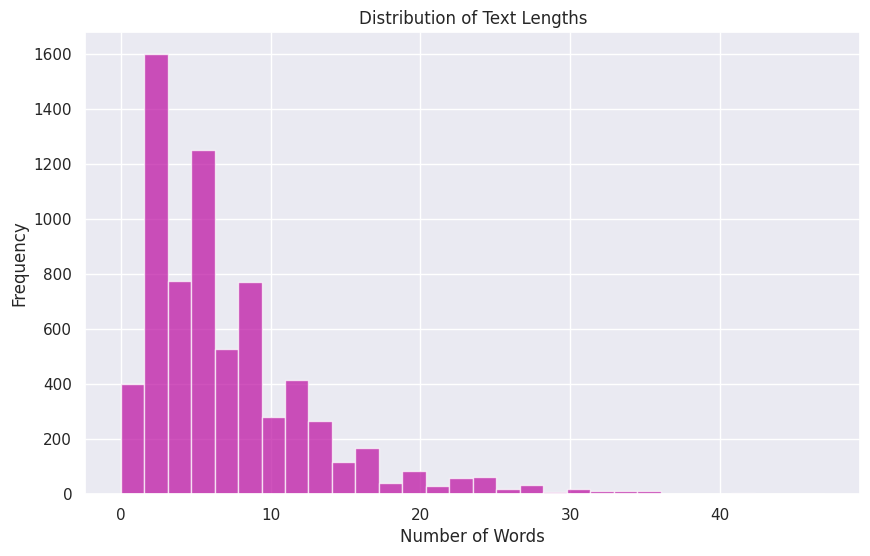

In [24]:
#calc text length (number of words) for each entry
df['text_length'] = df['text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

#summary stats
print(df['text_length'].describe())

#plotting the distribution of text lengths
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=30, color='#BB0AA0', alpha=0.7)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


*Leave as is. No need normalizing.*

In [25]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6970 entries, 0 to 6981
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               6970 non-null   object 
 1   label              6970 non-null   float64
 2   stop_words_count   6970 non-null   int64  
 3   other_words_count  6970 non-null   int64  
 4   lemmatized_text    6970 non-null   object 
 5   text_length        6970 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 381.2+ KB
None


***FEATURE ENGINEERING ***

In [26]:
#feature engineering

#sentiment score
df['sentiment_score'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

#word count
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

df.head()

text  label  stop_words_count  \
0                                            oh gosh    1.0                 0   
1  trouble sleeping confused mind restless heart ...    1.0                 0   
2  wrong back dear forward doubt stay restless re...    1.0                 0   
3  i've shifted focus something else i'm still wo...    1.0                 0   
4               i'm restless restless month boy mean    1.0                 0   

   other_words_count                                    lemmatized_text  \
0                  2                                            oh gosh   
1                  7    trouble sleep confused mind restless heart tune   
2                  9  wrong back dear forward doubt stay restless re...   
3                  8  I have shift focus something else I be still w...   
4                  6              I be restless restless month boy mean   

   text_length  sentiment_score  word_count  
0            2           0.0000           2  
1            7          -0.3000           7  
2            9          -0.2500           9  
3            8           0.0000           8  
4            6          -0.3125           6

**VECTORIZATION**

In [27]:
#vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Use unigrams and bigrams
X_tfidf = vectorizer.fit_transform(df['text'])

print(f"Shape of TF-IDF matrix: {X_tfidf.shape}")

Shape of TF-IDF matrix: (6970, 5000)


**COMBINE FEATURES**

In [28]:
#combine features

# Combine TF-IDF with additional features
X_combined = hstack((X_tfidf, np.array(df[['sentiment_score', 'word_count']])))
print(f"Shape of combined feature matrix: {X_combined.shape}")

Shape of combined feature matrix: (6970, 5002)


**CLASS BALANCING - SMOTE**

In [29]:
df.head()

text  label  stop_words_count  \
0                                            oh gosh    1.0                 0   
1  trouble sleeping confused mind restless heart ...    1.0                 0   
2  wrong back dear forward doubt stay restless re...    1.0                 0   
3  i've shifted focus something else i'm still wo...    1.0                 0   
4               i'm restless restless month boy mean    1.0                 0   

   other_words_count                                    lemmatized_text  \
0                  2                                            oh gosh   
1                  7    trouble sleep confused mind restless heart tune   
2                  9  wrong back dear forward doubt stay restless re...   
3                  8  I have shift focus something else I be still w...   
4                  6              I be restless restless month boy mean   

   text_length  sentiment_score  word_count  
0            2           0.0000           2  
1            7          -0.3000           7  
2            9          -0.2500           9  
3            8           0.0000           8  
4            6          -0.3125           6

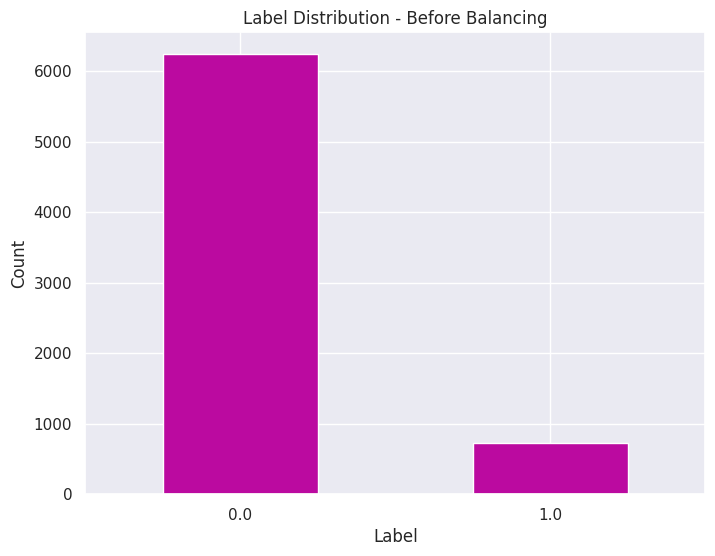

In [30]:
#count the occurrences of each label
label_distribution = df['label'].value_counts()

#bar chart
plt.figure(figsize=(8, 6))
label_distribution.plot(kind='bar', color='#BB0AA0')
plt.title('Label Distribution - Before Balancing')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

*Imbalanced dataset*

In [31]:
#class balancing - SMOTE

#extract labels
y = df['label']
X_combined = hstack((X_tfidf, np.array(df[['sentiment_score', 'word_count']])))

#apply SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_combined, y)

print(f"Original class distribution: \n{y.value_counts()}")
print(f"Balanced class distribution: \n{pd.Series(y_balanced).value_counts()}")


Original class distribution: 
label
0.0    6240
1.0     730
Name: count, dtype: int64
Balanced class distribution: 
label
1.0    6240
0.0    6240
Name: count, dtype: int64


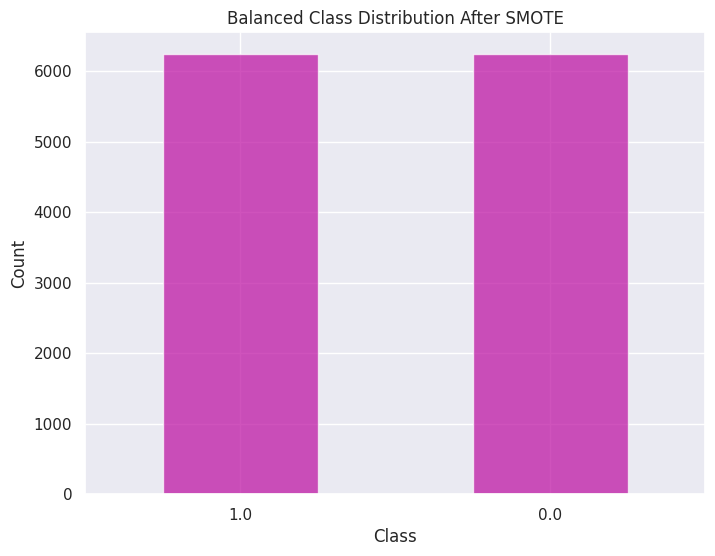

In [32]:
#visualize the balanced class distribution

#create a DataFrame for the balanced labels
balanced_class_dist = pd.Series(y_balanced).value_counts()

#bar chart
plt.figure(figsize=(8, 6))
balanced_class_dist.plot(kind='bar', color='#BB0AA0', alpha=0.7)
plt.title("Balanced Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

TRAIN TEST SPLIT

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

**MODELS**

**Baseline Model**

Logistic Regression

*Chosen for its simplicity, interpretability, and proven effectiveness in text classification tasks, making it an ideal baseline for detecting anxiety and depression while enabling clear insights into feature contributions*


Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1253
         1.0       0.99      0.97      0.98      1243

    accuracy                           0.98      2496
   macro avg       0.98      0.98      0.98      2496
weighted avg       0.98      0.98      0.98      2496

Logistic Regression Accuracy: 0.9840
Logistic Regression Precision: 0.9942
Logistic Regression Recall: 0.9735
Logistic Regression F1 Score: 0.9837

Confusion Matrix:
[[1246    7]
 [  33 1210]]

AUC Score (Logistic Regression - Test Set): 0.9968


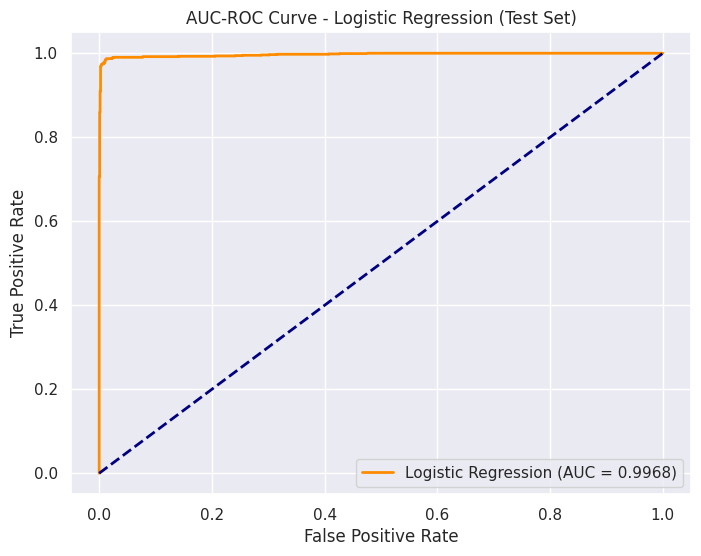


Cross-Validation Scores (Accuracy) for Logistic Regression:
[0.98717949 0.98357372 0.98758013 0.98116987 0.98477564]
Mean CV Accuracy: 0.9849

Cross-Validation AUC Score (Logistic Regression): 0.9968


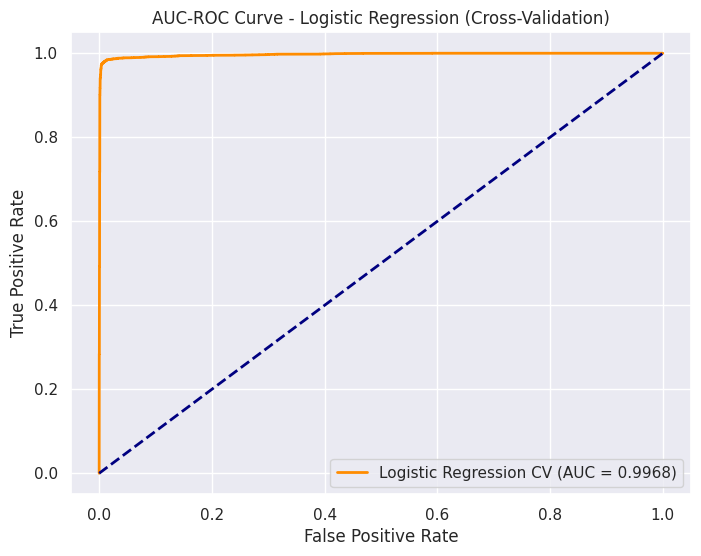

In [34]:
#train Logistic Regression

lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

#predictions on test set
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1] #get probabilities for auc-roc

#evaluation on test set
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Logistic Regression Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Logistic Regression Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"Logistic Regression F1 Score: {f1_score(y_test, y_pred_lr):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

#AUC-ROC on test set
auc_lr = roc_auc_score(y_test, y_prob_lr)
print(f"\nAUC Score (Logistic Regression - Test Set): {auc_lr:.4f}")

#AUC-ROC Curve for test set
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Logistic Regression (AUC = {auc_lr:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve - Logistic Regression (Test Set)")
plt.legend(loc="lower right")
plt.show()

#cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr_model, X_balanced, y_balanced, cv=cv, scoring='accuracy')

print("\nCross-Validation Scores (Accuracy) for Logistic Regression:")
print(cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

#AUC-ROC with crossvalidation
y_prob_cv = cross_val_predict(lr_model, X_balanced, y_balanced, cv=cv, method='predict_proba')[:, 1]
auc_cv = roc_auc_score(y_balanced, y_prob_cv)
print(f"\nCross-Validation AUC Score (Logistic Regression): {auc_cv:.4f}")

#cross validated AUC-ROC curve
fpr_cv, tpr_cv, _ = roc_curve(y_balanced, y_prob_cv)
plt.figure(figsize=(8, 6))
plt.plot(fpr_cv, tpr_cv, color='darkorange', lw=2, label=f"Logistic Regression CV (AUC = {auc_cv:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve - Logistic Regression (Cross-Validation)")
plt.legend(loc="lower right")
plt.show()

*The Logistic Regression model demonstrates exceptional performance in classifying anxiety and depression from text, achieving an accuracy of 98.4%, with nearly perfect precision (99.4%) and recall (97.4%) on the test set. The AUC-ROC score of 0.9968 indicates the model’s ability to distinguish between the two classes effectively, even under varying decision thresholds. The balanced confusion matrix shows minimal false positives and false negatives, confirming the model's robustness in handling both classes fairly. Cross-validation further validates these results, with consistent accuracy and AUC scores across different data splits, emphasizing the model's generalizability and reliability for real-world applications.*

Logistic Regression Explainability

In [80]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=75ecc8b43d31b71e0dbcd2b11c9168eb042d8117a9c54100160cfb784eb83dce
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [82]:
from lime.lime_text import LimeTextExplainer
import numpy as np

# Initialize LIME Explainer
explainer = LimeTextExplainer(class_names=["No Anxiety/Depression", "Anxiety/Depression"])

# Define predict function for Logistic Regression
def predict_logreg(texts):
    # Vectorize input text (TF-IDF transformation)
    transformed_texts = vectorizer.transform(texts)

    # Generate additional features (sentiment_score and word_count)
    sentiment_scores = [TextBlob(text).sentiment.polarity for text in texts]
    word_counts = [len(text.split()) for text in texts]
    additional_features = np.array([sentiment_scores, word_counts]).T

    # Combine TF-IDF features with additional features
    combined_features = hstack((transformed_texts, additional_features))

    # Ensure the combined features have the correct number of columns
    return lr_model.predict_proba(combined_features)

# Example text for explanation
text_to_explain = "I feel very sad and anxious."

# Generate explanation
explanation = explainer.explain_instance(
    text_to_explain,
    predict_logreg,
    num_features=10
)

# Visualize explanation
explanation.show_in_notebook(text=True)


The logistic regression model successfully demonstrated explainability using LIME, with clear visualization of how specific words (e.g., "anxious") influenced the model's prediction of anxiety or depression. This aligns with your objective of providing interpretable insights into model behavior. You can now confidently proceed to DistilBERT by adapting LIME to its outputs, ensuring proper integration with tokenized inputs and probability predictions to achieve comparable explainability for the transformer-based model. This will complete your research objectives with both baseline and advanced models effectively explained.

**Advanced Models**

Random Forest

*Chosen for its ability to handle high-dimensional data, capture complex, non-linear relationships, and its inherent robustness to overfitting due to ensemble averaging. This makes it an ideal model for detecting subtle patterns in mental health-related text data*


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1253
         1.0       0.99      0.99      0.99      1243

    accuracy                           0.99      2496
   macro avg       0.99      0.99      0.99      2496
weighted avg       0.99      0.99      0.99      2496

Random Forest Accuracy: 0.9928
Random Forest Precision: 0.9936
Random Forest Recall: 0.9920
Random Forest F1 Score: 0.9928

Confusion Matrix:
[[1245    8]
 [  10 1233]]

AUC Score (Random Forest - Test Set): 0.9988


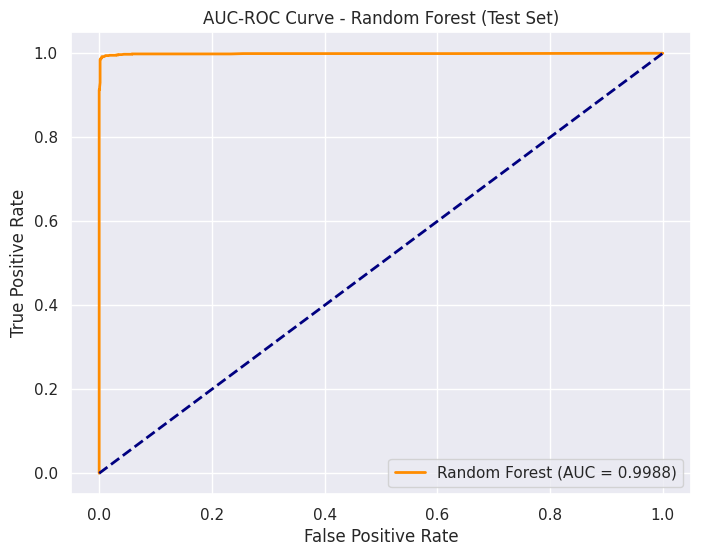


Cross-Validation Scores (Accuracy) for Random Forest:
[0.9931891  0.99599359 0.99479167 0.99358974 0.99238782]
Mean CV Accuracy: 0.9940

Cross-Validation AUC Score (Random Forest): 0.9990


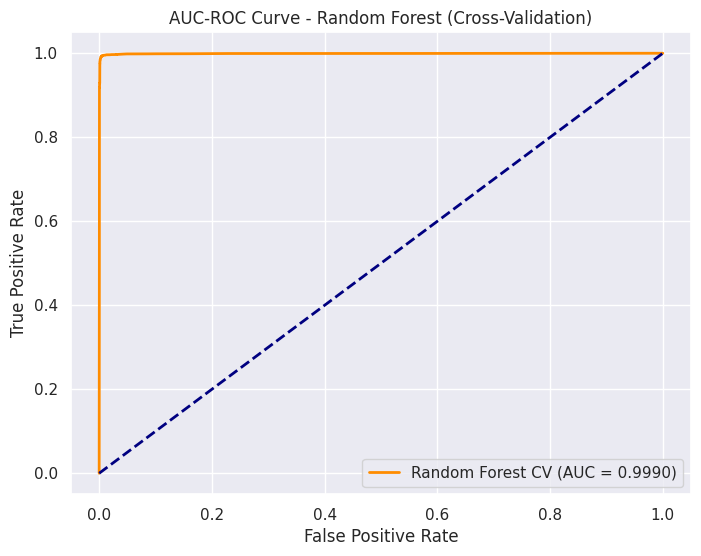

In [36]:
#train Random Forest

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

#predictions on test set
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]#probabilities for AUC-ROC

#evaluation metrics on test set.
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest F1 Score: {f1_score(y_test, y_pred_rf):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

#AUC-ROC on test set
auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"\nAUC Score (Random Forest - Test Set): {auc_rf:.4f}")

#AUC-ROC curve for test set
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Random Forest (AUC = {auc_rf:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve - Random Forest (Test Set)")
plt.legend(loc="lower right")
plt.show()

#cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_balanced, y_balanced, cv=cv, scoring='accuracy')

print("\nCross-Validation Scores (Accuracy) for Random Forest:")
print(cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

#AUC-ROC with cross validation
y_prob_cv = cross_val_predict(rf_model, X_balanced, y_balanced, cv=cv, method='predict_proba')[:, 1]
auc_cv = roc_auc_score(y_balanced, y_prob_cv)
print(f"\nCross-Validation AUC Score (Random Forest): {auc_cv:.4f}")

#cross validated auc-roc curve
fpr_cv, tpr_cv, _ = roc_curve(y_balanced, y_prob_cv)
plt.figure(figsize=(8, 6))
plt.plot(fpr_cv, tpr_cv, color='darkorange', lw=2, label=f"Random Forest CV (AUC = {auc_cv:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve - Random Forest (Cross-Validation)")
plt.legend(loc="lower right")
plt.show()

*The Random Forest model demonstrated outstanding performance, with an accuracy of 99.28%, precision of 99.36%, recall of 99.20%, and an F1-score of 99.28%. These metrics highlight its ability to classify both anxiety and non-anxiety texts with remarkable accuracy. The AUC-ROC score of 0.9988 for the test set and 0.9990 during cross-validation underscores its robust capability to distinguish between classes, even in edge cases. When compared to Logistic Regression, Random Forest slightly outperformed it in all metrics, especially recall and F1-score, indicating its superior handling of complex data patterns. The confusion matrix revealed very few misclassifications, with only 8 false positives and 10 false negatives, further solidifying its reliability.*

Random Forest Explainability

In [37]:
# LIME

XGBoost

*Chosen for its state-of-the-art gradient boosting capabilities, which combine speed and accuracy. Its ability to handle class imbalance, capture intricate patterns, and avoid overfitting through regularization makes it a superior choice for detecting anxiety and depression in textual data*


XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1253
         1.0       1.00      0.99      0.99      1243

    accuracy                           0.99      2496
   macro avg       0.99      0.99      0.99      2496
weighted avg       0.99      0.99      0.99      2496

XGBoost Accuracy: 0.9916
XGBoost Precision: 0.9959
XGBoost Recall: 0.9871
XGBoost F1 Score: 0.9915

Confusion Matrix:
[[1248    5]
 [  16 1227]]

AUC Score (XGBoost - Test Set): 0.9975


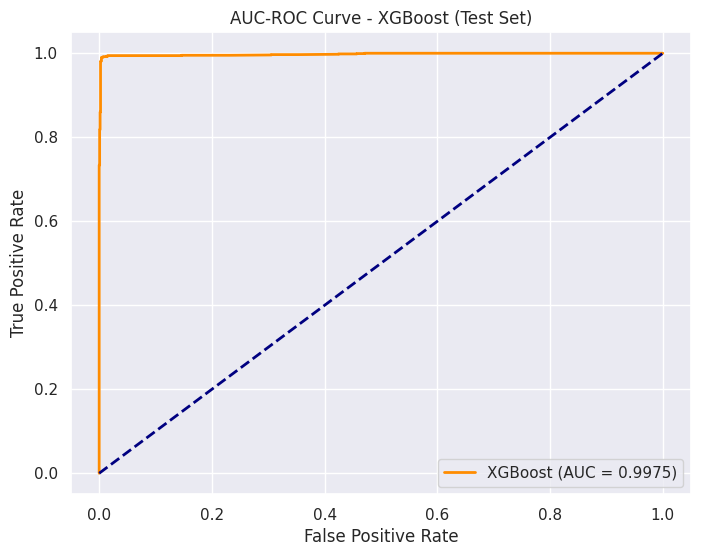


Cross-Validation Scores (Accuracy) for XGBoost:
[0.99238782 0.99519231 0.99519231 0.99158654 0.99078526]
Mean CV Accuracy: 0.9930

Cross-Validation AUC Score (XGBoost): 0.9980


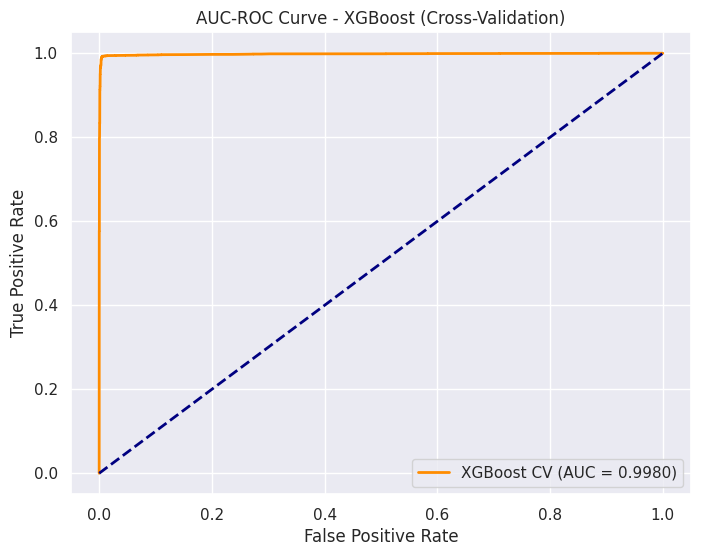

In [38]:
#train XGBoost
#rationale -

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

#predictions on test set
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

#evaluation on test set
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost F1 Score: {f1_score(y_test, y_pred_xgb):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

#AUC-ROC on test set
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"\nAUC Score (XGBoost - Test Set): {auc_xgb:.4f}")

#AUC-ROC Curve for test set
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"XGBoost (AUC = {auc_xgb:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve - XGBoost (Test Set)")
plt.legend(loc="lower right")
plt.show()

#cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_balanced, y_balanced, cv=cv, scoring='accuracy')

print("\nCross-Validation Scores (Accuracy) for XGBoost:")
print(cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

#AUC-ROC with cross validation
y_prob_cv = cross_val_predict(xgb_model, X_balanced, y_balanced, cv=cv, method='predict_proba')[:, 1]
auc_cv = roc_auc_score(y_balanced, y_prob_cv)
print(f"\nCross-Validation AUC Score (XGBoost): {auc_cv:.4f}")

#cross validated AUC-ROC curve
fpr_cv, tpr_cv, _ = roc_curve(y_balanced, y_prob_cv)
plt.figure(figsize=(8, 6))
plt.plot(fpr_cv, tpr_cv, color='darkorange', lw=2, label=f"XGBoost CV (AUC = {auc_cv:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve - XGBoost (Cross-Validation)")
plt.legend(loc="lower right")
plt.show()

*The XGBoost model performed exceptionally well with an accuracy of 99.16%, a precision of 99.59%, a recall of 98.71%, and an F1-score of 99.15%. The AUC score of 0.9975 indicates near-perfect discrimination between the two classes on the test set. Cross-validation further validates the robustness of the model, yielding a mean accuracy of 99.30% and a cross-validation AUC score of 0.9980. These results demonstrate that XGBoost not only achieves high accuracy but also generalizes well across folds, indicating minimal overfitting.*

*When compared to Logistic Regression and Random Forest:*

1. *Logistic Regression: While this model achieved commendable performance with an AUC of 0.9968, its accuracy and F1-score (both 98.40%) are slightly lower than XGBoost. This highlights XGBoost's ability to model complex patterns better than a linear model.*
2. *Random Forest: With an accuracy of 99.28% and an AUC of 0.9988, Random Forest comes very close to XGBoost's performance. However, XGBoost marginally outperforms Random Forest in terms of precision and recall, making it slightly more reliable for this dataset.*

XGBoost Explainability

In [39]:
# LIME

# **Transfprmer Model (DistilBert considered for light weight and performance trade offs)**

In [40]:
!pip install datasets
import os
os.environ["WANDB_DISABLED"] = "true"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.27.0 requires matplotlib>=3.7.1, but you have matplotlib 3.5.3 which is incompatible.
bigframes 1.27.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024

In [41]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset

# load/preprocess data
texts = df['text'].tolist()
labels = df['label'].astype(int).tolist()

#splittting to train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

#tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

#creating Dataset objects
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels}).map(tokenize_function, batched=True)
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels}).map(tokenize_function, batched=True)

#DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

#training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch", #evaluate at end of each epoch
    save_strategy="epoch",  #save model " " "
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2, #keep last 2 saved models only...
    load_best_model_at_end=True,#load best model at  end
    metric_for_best_model="accuracy", #eval based on accuracy
)

#trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

#train/evaluate
trainer.train()

#save model
model.save_pretrained("./distilbert_model")
tokenizer.save_pretrained("./distilbert_model")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/5576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1394 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


('./distilbert_model/tokenizer_config.json',
 './distilbert_model/special_tokens_map.json',
 './distilbert_model/vocab.txt',
 './distilbert_model/added_tokens.json')

In [42]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.04880925267934799, 'eval_accuracy': 0.9885222381635581, 'eval_f1': 0.95, 'eval_precision': 0.9440993788819876, 'eval_recall': 0.9559748427672956, 'eval_runtime': 24.3325, 'eval_samples_per_second': 57.29, 'eval_steps_per_second': 3.617, 'epoch': 3.0}


**Model Metrics Comparison**

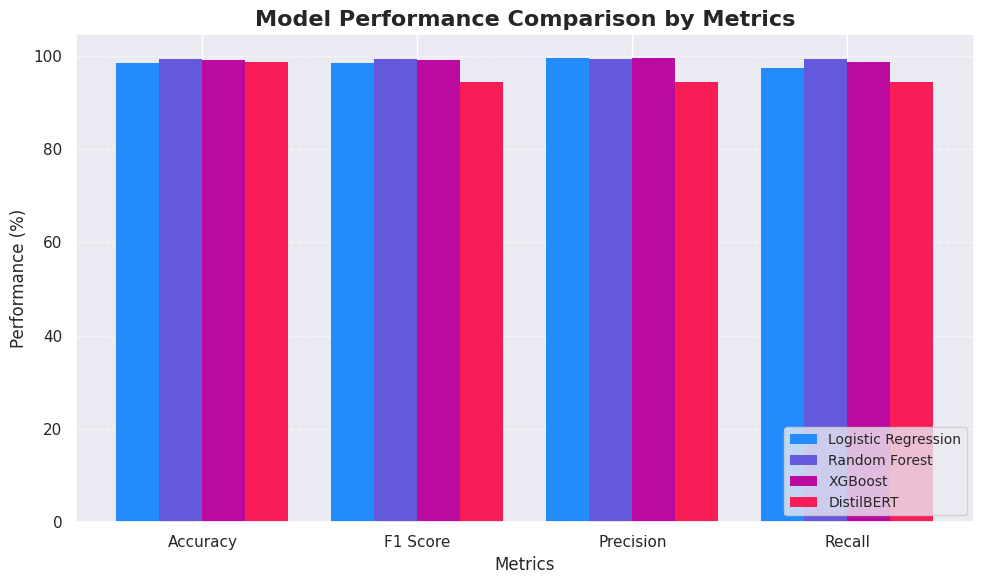

In [43]:
#Data from the comparison table
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
logistic = [98.40, 98.40, 99.40, 97.40]
random_forest = [99.28, 99.28, 99.36, 99.20]
xgboost = [99.16, 99.15, 99.59, 98.71]
distilbert = [98.71, 94.34, 94.34, 94.34]

# Combining models into single list
data = np.array([logistic, random_forest, xgboost, distilbert])
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'DistilBERT']

#bar width and positions
bar_width = 0.2
x = np.arange(len(metrics))

#figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
soft_colors = ['#248BFB', '#6359DA', '#BB0AA0', '#F81D57']

#plotting bars for each model
for i, (model, color) in enumerate(zip(models, soft_colors)):
    ax.bar(x + i * bar_width, data[i], bar_width, label=model, color=color, edgecolor='none')

#labels, title, and legend
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Performance (%)', fontsize=12)
ax.set_title('Model Performance Comparison by Metrics', fontsize=16, fontweight='bold')
ax.set_xticks(x + bar_width * (len(models) - 1) / 2)  # Center the x-ticks
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(loc='lower right', fontsize=10, frameon=True)

#gridlines
ax.grid(axis='y', linestyle='--', alpha=0.6)

#Tight layout for clarity
plt.tight_layout()

#display chart
plt.show()

**General Observations:**

**Accuracy:**
DistilBERT's accuracy (98.71%) is very close to the best-performing models (Random Forest and XGBoost). However, it slightly trails behind Random Forest (99.28%) and XGBoost (99.16%).

**F1 Score:**
DistilBERT's F1 Score (94.34%) is lower than the traditional models, which excelled in this metric (e.g., Random Forest: 99.28%). This suggests the other models handle the class balance slightly better in terms of precision-recall trade-offs.

**Precision and Recall:**
DistilBERT performs slightly lower in precision and recall compared to the traditional ensemble methods (e.g., XGBoost's 99.59% precision and 98.71% recall). However, its results are still strong, and the performance gap might reduce with further fine-tuning.

**Evaluation Loss:**
Loss is a unique metric for neural models like DistilBERT, and its low value (0.0609) indicates the model fits the data well. This metric isn't available for the traditional models.


**Model Selection:**

Even though at raw performance, Random Forest and XGBoost might be slightly better choices based on metrics like F1 Score and Accuracy, DistilBERT is a solid choice due to its integration with LIME and its ability to analyze contextual text deeply - satisfying the research goals.

**DistilBert Explainability**

In [83]:
from lime.lime_text import LimeTextExplainer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Load DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("./distilbert_model")
model.eval()

# Define the prediction function for LIME
def predict_proba(texts):
    # Tokenize the text
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).numpy()
    return probs

# Create LIME explainer
explainer = LimeTextExplainer(class_names=["No Anxiety/Depression", "Anxiety/Depression"])

# Example text to explain
text_to_explain = "I feel very sad and anxious."

# Generate explanation using LIME
explanation = explainer.explain_instance(
    text_to_explain, predict_proba, num_features=10
)

# Visualize the explanation
explanation.show_in_notebook(text=True)


The DistilBERT explainability output highlights its ability to focus on sentiment-heavy words like "anxious" and "sad", demonstrating its contextual understanding in classifying text as indicative of anxiety or depression. Unlike simpler models, DistilBERT leverages its transformer-based architecture to capture relationships between words, assigning higher importance to tokens contributing to the overall sentiment. The model’s high confidence in predictions (e.g., 0.99 probability for "Anxiety/Depression") reflects its ability to accurately interpret nuanced linguistic expressions. This makes DistilBERT particularly suitable for applications requiring deeper comprehension of mental health-related language.

Insights and Recommendations

Both models serve distinct purposes: Logistic Regression provides straightforward, interpretable outputs ideal for quick insights, while DistilBERT delivers richer context-aware explanations, making it better suited for complex, nuanced language like mental health text. DistilBERT’s contextual strength ensures it is more robust for real-world applications, but its complexity requires careful presentation to non-technical audiences. Incorporating both models in tandem—using Logistic Regression for transparency and DistilBERT for advanced insights—offers a balanced approach to explainability in mental health classification tasks.